### Import Libraries

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV


### Load Data into DataFrame

In [4]:
def load_data(base_path):
    connectome = pd.read_csv(os.path.join(base_path, "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"))
    quantitative = pd.read_excel(os.path.join(base_path, "TRAIN_QUANTITATIVE_METADATA_new.xlsx"))
    categorical = pd.read_excel(os.path.join(base_path, "TRAIN_CATEGORICAL_METADATA_new.xlsx"))
    solution = pd.read_excel(os.path.join(base_path, "TRAINING_SOLUTIONS.xlsx"))

    for df in [connectome, quantitative, categorical, solution]:
        df['participant_id'] = df['participant_id'].astype(str)

    return connectome, quantitative, categorical, solution

In [5]:
def merge_and_preprocess(connectome, quantitative, categorical, solution):
    df = solution.merge(categorical, on='participant_id', how='left') \
                 .merge(quantitative, on='participant_id', how='left') \
                 .merge(connectome, on='participant_id', how='left')
    df.set_index('participant_id', inplace=True)
    return df

In [6]:
def check_for_nulls(df):
  """
  Checks for null values in a pandas DataFrame and prints a message.

  Args:
    df: The pandas DataFrame to check.

  Returns:
    None
  """
  if df.isnull().any().any():
    print("The DataFrame contains null values.")
  else:
    print("The DataFrame does not contain null values.")

In [7]:
base_path = "widsdatathon2025/TRAIN_NEW"
connectome, quantitative, categorical, solution = load_data(base_path)

In [8]:
df = merge_and_preprocess(connectome, quantitative, categorical, solution)

In [9]:
print("data merged! Shape:", df.shape)

data merged! Shape: (1213, 19929)


In [10]:
targets = ['ADHD_Outcome', 'Sex_F']
non_connectome_features = [col for col in df.columns if not (col.startswith('0throw') or col.startswith('1throw') or 
                                                             col.startswith('2throw') or col.startswith('3throw') or 
                                                             col.startswith('4throw') or col.startswith('5throw') or
                                                             col.startswith('6throw') or col.startswith('7throw') or
                                                             col.startswith('8throw') or col.startswith('9throw') or
                                                             col in targets)]

connectome_features = [col for col in df.columns if (col.startswith('0throw') or col.startswith('1throw') or 
                                                      col.startswith('2throw') or col.startswith('3throw') or 
                                                      col.startswith('4throw') or col.startswith('5throw') or
                                                      col.startswith('6throw') or col.startswith('7throw') or
                                                      col.startswith('8throw') or col.startswith('9throw'))]

In [11]:
df.describe()

,ADHD_Outcome,Sex_F,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
count,1213.000000,1213.000000,1213.000000,1213.000000,1170.000000,1159.000000,1210.000000,1198.000000,1182.000000,1015.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,0.685078,0.342951,2017.652102,2.014839,0.435897,2.177739,2.294215,17.862270,25.545685,16.876847,...,0.044413,-0.079307,-0.037423,0.009393,0.557159,0.376624,0.370711,0.500415,0.476418,0.543181
std,0.464676,0.474891,1.122522,1.135147,0.693174,3.204782,0.750660,3.505608,16.757043,3.929558,...,0.191253,0.204061,0.205052,0.198820,0.150605,0.197995,0.191249,0.177047,0.177732,0.170237
min,0.000000,0.000000,2015.000000,1.000000,0.000000,0.000000,1.000000,3.000000,0.000000,3.000000,...,-0.547155,-0.620350,-0.584162,-0.605647,-0.052284,-0.359869,-0.553067,-0.302408,-0.307228,-0.224057
25%,0.000000,0.000000,2017.000000,1.000000,0.000000,0.000000,2.000000,15.000000,5.000000,15.000000,...,-0.087566,-0.220508,-0.187871,-0.124404,0.469147,0.262601,0.242569,0.389078,0.367971,0.442283
50%,1.000000,0.000000,2018.000000,1.000000,0.000000,1.000000,2.000000,18.000000,30.000000,18.000000,...,0.043204,-0.093695,-0.044155,0.004375,0.573840,0.391739,0.388528,0.524508,0.496103,0.566455
75%,1.000000,1.000000,2019.000000,3.000000,1.000000,2.000000,3.000000,21.000000,40.000000,21.000000,...,0.177608,0.049707,0.104526,0.146865,0.666128,0.521904,0.505970,0.630443,0.600065,0.667402
max,1.000000,1.000000,2020.000000,4.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,...,0.670512,0.596618,0.630932,0.666169,0.889148,0.866371,0.828784,0.914021,0.898459,0.903364


In [12]:
check_for_nulls(df)

The DataFrame contains null values.


### Cleaning the Data

In [13]:
missing = df.isnull().sum()
missing_percent = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_percent
})


missing_features = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("\nFeatures with missing values in training data:")
missing_features


Features with missing values in training data:


,Missing Values,Percentage
MRI_Track_Age_at_Scan,360,29.678483
Barratt_Barratt_P2_Occ,222,18.301731
Barratt_Barratt_P2_Edu,198,16.323166
PreInt_Demos_Fam_Child_Race,54,4.451772
PreInt_Demos_Fam_Child_Ethnicity,43,3.544930
Barratt_Barratt_P1_Occ,31,2.555647
ColorVision_CV_Score,23,1.896125
Barratt_Barratt_P1_Edu,15,1.236603
EHQ_EHQ_Total,13,1.071723
APQ_P_APQ_P_PM,12,0.989283


In [14]:
columns_with_missing = missing_features.index.tolist()
print(f"Number of columns with missing values: {len(columns_with_missing)}")

imputer = SimpleImputer(strategy='mean')

df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])


missing_after = df[columns_with_missing].isnull().sum().sum()
print(f"Missing values after imputation: {missing_after}")
print("All missing values have been replaced with column means")

Number of columns with missing values: 25
Missing values after imputation: 0
All missing values have been replaced with column means


In [16]:
# Categorical columns - we'll use the most common value to fill in missing data
categorical_columns = [
    'Barratt_Barratt_P1_Edu', 
    'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P1_Occ',
    'Barratt_Barratt_P2_Occ',
    'PreInt_Demos_Fam_Child_Race'
]

# Numerical columns - we'll use the average value to fill in missing data
numerical_columns = [
    'SDQ_SDQ_Difficulties_Total',
    'SDQ_SDQ_Prosocial',
    'SDQ_SDQ_Peer_Problems',
    'SDQ_SDQ_Internalizing',
    'SDQ_SDQ_Hyperactivity',
    'SDQ_SDQ_Generating_Impact',
    'SDQ_SDQ_Emotional_Problems',
    'SDQ_SDQ_Externalizing',
    'SDQ_SDQ_Conduct_Problems',
    'APQ_P_APQ_P_PP',
    'APQ_P_APQ_P_PM',
    'APQ_P_APQ_P_OPD',
    'APQ_P_APQ_P_INV',
    'APQ_P_APQ_P_ID',
    'APQ_P_APQ_P_CP',
    'ColorVision_CV_Score',
    'EHQ_EHQ_Total'
]


mode_imputer = SimpleImputer(strategy='most_frequent')  # For categorical data
mean_imputer = SimpleImputer(strategy='mean')           # For numerical data


print("Filling in missing categorical data with most common values...")
mode_imputer.fit(df[categorical_columns])  


print("Filling in missing numerical data with average values...")
mean_imputer.fit(df[numerical_columns])  


Filling in missing categorical data with most common values...
Filling in missing numerical data with average values...


SimpleImputer()

In [17]:
check_for_nulls(df)

The DataFrame does not contain null values.


### EDA

In [36]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(exclude=['object']).columns

# Print counts of categorical vs numerical
print(f"Categorical Columns: {len(categorical_cols)}")
print(f"Numerical Columns: {len(numerical_cols)}")

Categorical Columns: 0
Numerical Columns: 19929


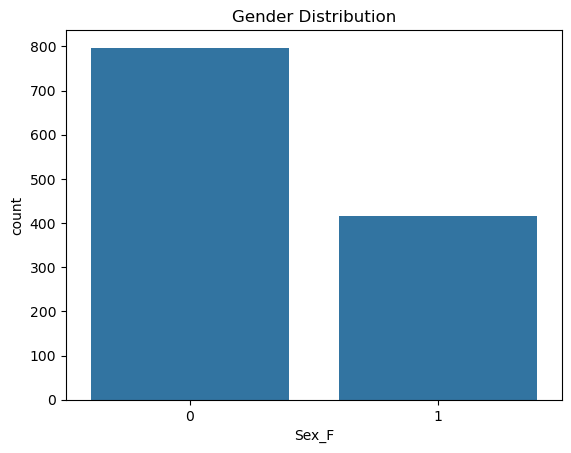

In [42]:
sns.countplot(data=df, x='Sex_F')
plt.title('Gender Distribution')
plt.show()

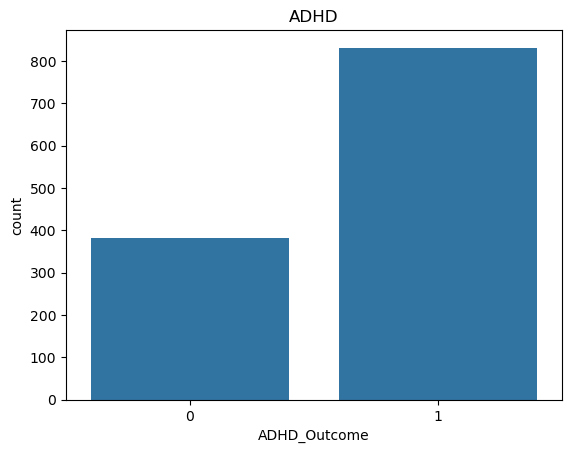

In [44]:
sns.countplot(data=df, x='ADHD_Outcome')
plt.title('ADHD')
plt.show()

In [ ]:
### Unbalanced 

### Split the Data

In [18]:
y = df[['ADHD_Outcome', 'Sex_F']]
X = df.drop(columns=['ADHD_Outcome', 'Sex_F'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Scale the Data for KNN, Logistic Regression, and Neural Networks

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
y.shape

(1213, 2)

### KNN Model

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Define base model
knn = KNeighborsClassifier()

# 2. Wrap with MultiOutputClassifier
multi_knn = MultiOutputClassifier(knn)

# 3. Define hyperparameter grid
param_grid = {
    'estimator__n_neighbors': list(range(1, 31)),
    'estimator__weights': ['uniform', 'distance'],
    'estimator__metric': ['euclidean', 'manhattan', 'minkowski']
}

# 4. Create GridSearchCV object
grid_search = GridSearchCV(multi_knn, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 5. Fit on scaled training data
grid_search.fit(X_train_scaled, y_train)

# 6. Best parameters and accuracy
print("✅ Best parameters:", grid_search.best_params_)
print("✅ Best CV accuracy:", grid_search.best_score_)

# 7. Final model prediction and test accuracy
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate for each output separately
for i in range(y_test.shape[1]):
    acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"✅ Test accuracy for output {i+1}: {acc:.4f}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
✅ Best parameters: {'estimator__metric': 'manhattan', 'estimator__n_neighbors': 29, 'estimator__weights': 'uniform'}
✅ Best CV accuracy: 0.4345631743821789
✅ Test accuracy for output 1: 0.6154
✅ Test accuracy for output 2: 0.6731


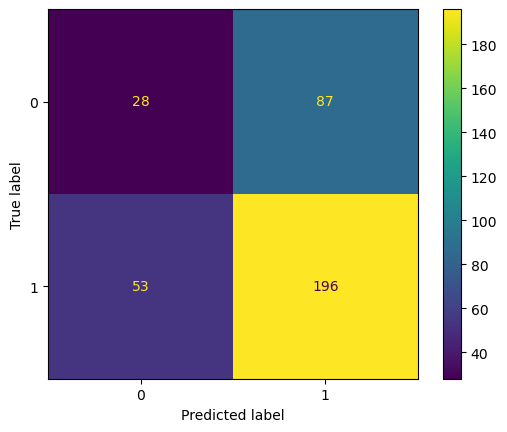

In [55]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure numpy arrays
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# ADHD (output 1)
cm_adhd = confusion_matrix(y_test_np[:, 0], y_pred_np[:, 0])
ConfusionMatrixDisplay(cm_adhd).plot()

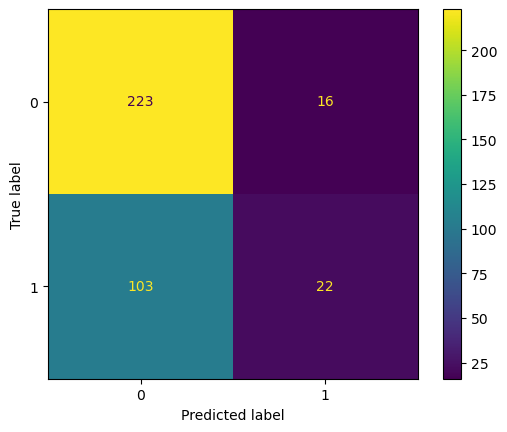

In [56]:
cm_gender = confusion_matrix(y_test_np[:, 1], y_pred_np[:, 1])
ConfusionMatrixDisplay(cm_gender).plot()

In [59]:
from sklearn.metrics import classification_report

print("ADHD Classification Report:")
print(classification_report(y_test_np[:, 0], y_pred_np[:, 0]))

print("Gender Classification Report:")
print(classification_report(y_test_np[:, 1], y_pred_np[:, 1]))


ADHD Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.24      0.29       115
           1       0.69      0.79      0.74       249

    accuracy                           0.62       364
   macro avg       0.52      0.52      0.51       364
weighted avg       0.58      0.62      0.59       364

Gender Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       239
           1       0.58      0.18      0.27       125

    accuracy                           0.67       364
   macro avg       0.63      0.55      0.53       364
weighted avg       0.65      0.67      0.61       364



### Logestic Model

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

# Define the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Wrap it in MultiOutputClassifier
multi_log_reg = MultiOutputClassifier(log_reg)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'estimator__solver': ['lbfgs', 'liblinear'],  # Solvers for optimization
    'estimator__penalty': ['l2'],  # Penalty type (l1 is only for liblinear)
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(multi_log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best cross-validation accuracy
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Predict using the best model
y_pred = grid_search.predict(X_test_scaled)

# Classification reports
print("ADHD_Outcome Classification Report:")
print(classification_report(y_test['ADHD_Outcome'], y_pred[:, 0]))

print("Sex_F Classification Report:")
print(classification_report(y_test['Sex_F'], y_pred[:, 1]))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Best CV accuracy: 0.5159276018099547
ADHD_Outcome Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.34      0.40       115
           1       0.73      0.83      0.78       249

    accuracy                           0.67       364
   macro avg       0.60      0.58      0.59       364
weighted avg       0.65      0.67      0.66       364

Sex_F Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       239
           1       0.67      0.49      0.56       125

    accuracy                           0.74       364
   macro avg       0.72      0.68      0.69       364
weighted avg       0.73      0.74      0.73       364



### Decision Trees

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Step 1: Base model
dt = DecisionTreeClassifier(random_state=42)

# Step 2: Wrap it for multi-output classification
multi_dt = MultiOutputClassifier(dt)

# Step 3: Define hyperparameter grid
param_grid = {
    'estimator__criterion': ['gini'],           # Splitting criteria
    'estimator__max_depth': [None, 5, 10],             # Tree depth
    'estimator__min_samples_split': [2, 5, 10],            # Min samples to split
    'estimator__min_samples_leaf': [1, 2, 4],              # Min samples per leaf
    'estimator__max_features': [None, 'sqrt', 'log2'],     # Feature selection
}

# Step 4: GridSearchCV
grid_search = GridSearchCV(
    estimator=multi_dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Step 5: Fit model
grid_search.fit(X_train_scaled, y_train)

# Step 6: Evaluation
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Step 7: Predict and report
y_pred = grid_search.predict(X_test_scaled)

print("\n ADHD_Outcome Classification Report:")
print(classification_report(y_test['ADHD_Outcome'], y_pred[:, 0]))

print("\n Sex_F Classification Report:")
print(classification_report(y_test['Sex_F'], y_pred[:, 1]))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Best cross-validation accuracy: 0.42634876435781416

 ADHD_Outcome Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       115
           1       0.80      0.86      0.83       249

    accuracy                           0.75       364
   macro avg       0.71      0.69      0.70       364
weighted avg       0.74      0.75      0.75       364


 Sex_F Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.69       239
           1       0.29      0.20      0.24       125

    accuracy                           0.55       364
   macro avg       0.46      0.47      0.46       364
weighted avg       0.52      0.55      

### RandomForestClassifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint

# Step 1: Define base model
rf = RandomForestClassifier(random_state=42)
multi_rf = MultiOutputClassifier(rf)

# Step 2: Define parameter distributions
param_dist = {
    'estimator__n_estimators': randint(50, 150),
    'estimator__max_depth': randint(5, 20),
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(1, 5),
    'estimator__max_features': ['sqrt', 'log2']
}

# Step 3: Use RandomizedSearchCV for speed
random_search = RandomizedSearchCV(
    multi_rf,
    param_distributions=param_dist,
    n_iter=20,           # Try reducing this to 10 if still slow
    cv=3,                # 3-fold is fast and often reliable
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Step 4: Fit the model
random_search.fit(X_train_scaled, y_train)

# Step 5: Evaluate
y_pred = random_search.predict(X_test_scaled)

print("Best parameters:", random_search.best_params_)

print("\nADHD_Outcome Classification Report:")
print(classification_report(y_test['ADHD_Outcome'], y_pred[:, 0]))

print("\nSex_F Classification Report:")
print(classification_report(y_test['Sex_F'], y_pred[:, 1]))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'estimator__max_depth': 8, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 7, 'estimator__n_estimators': 58}

ADHD_Outcome Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       115
           1       0.69      1.00      0.81       249

    accuracy                           0.69       364
   macro avg       0.84      0.50      0.42       364
weighted avg       0.79      0.69      0.56       364


Sex_F Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.99      0.79       239
           1       0.67      0.03      0.06       125

    accuracy                           0.66       364
   macro avg       0.66      0.51      0.43       364
weighted avg       0.66      0.66      0.54       364



### Neural Network

In [33]:
from sklearn.neural_network import MLPClassifier

# Define a dictionary of classifiers
classifiers = {
    'Neural Network': MLPClassifier(random_state=42)
}

# Iterate through classifiers
for name, clf in classifiers.items():
    print(f"\n{name}")
    multi_clf = MultiOutputClassifier(clf)
    multi_clf.fit(X_train, y_train)
    y_pred = multi_clf.predict(X_test)
    print("ADHD_Outcome Classification Report:")
    print(classification_report(y_test['ADHD_Outcome'], y_pred[:, 0]))
    print("Sex_F Classification Report:")
    print(classification_report(y_test['Sex_F'], y_pred[:, 1]))


Neural Network
ADHD_Outcome Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       115
           1       0.78      0.83      0.80       249

    accuracy                           0.72       364
   macro avg       0.67      0.66      0.66       364
weighted avg       0.71      0.72      0.72       364

Sex_F Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       239
           1       0.68      0.49      0.57       125

    accuracy                           0.74       364
   macro avg       0.72      0.68      0.69       364
weighted avg       0.74      0.74      0.73       364

